**Dataset URL**

https://blog.gdeltproject.org/a-new-dataset-for-exploring-climate-change-narratives-on-television-news-2009-2020/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models

In [ ]:

csv_files = glob.glob('/content/*.csv')

df_list = []

for filename in csv_files:
    try:
        df_list.append(pd.read_csv(filename))
    except pd.errors.EmptyDataError:
        print(f"EmptyDataError occurred when reading file: {filename}. Skipping this file.")

df = pd.concat(df_list, ignore_index=True)


EmptyDataError occurred when reading file: /content/CNN.200910.csv. Skipping this file.


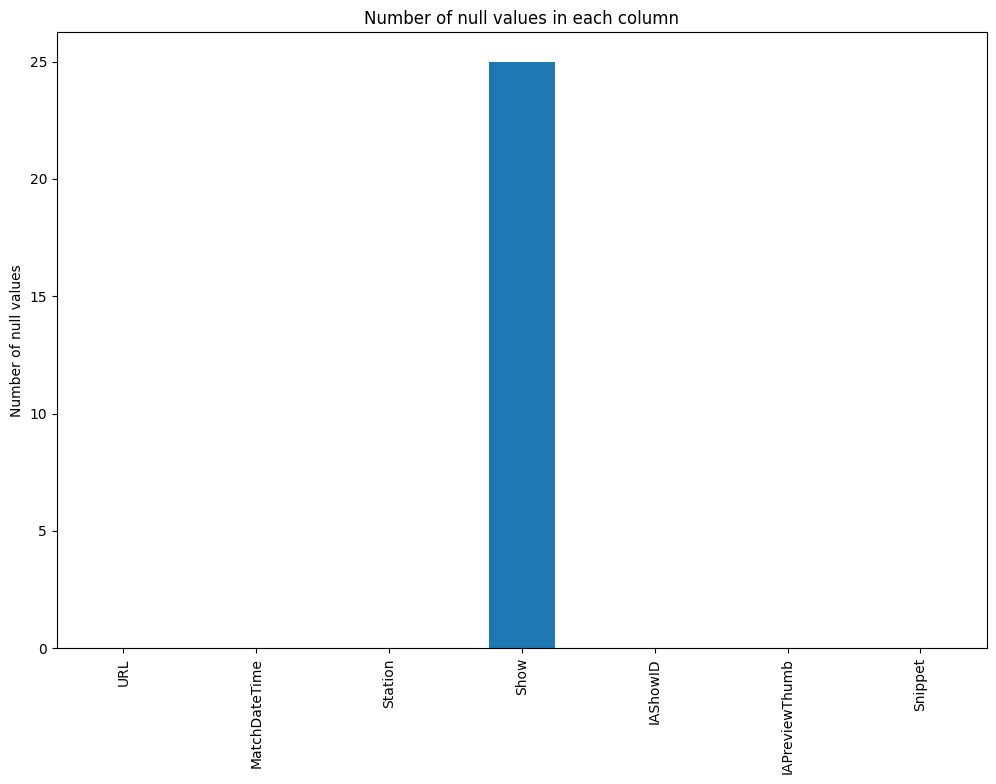

In [ ]:
null_counts = df.isna().sum()
plt.figure(figsize=(12,8))
null_counts.plot(kind='bar')
plt.title('Number of null values in each column')
plt.ylabel('Number of null values')
plt.show()

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = " ".join(words)

    return text

df['Snippet'] = df['Snippet'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df['MatchDateTime'] = pd.to_datetime(df['MatchDateTime'])
df['Day'] = df['MatchDateTime'].dt.day
df['Month'] = df['MatchDateTime'].dt.month
df['Year'] = df['MatchDateTime'].dt.year
df['Time'] = df['MatchDateTime'].dt.time
df.drop(columns=['MatchDateTime'], inplace=True)


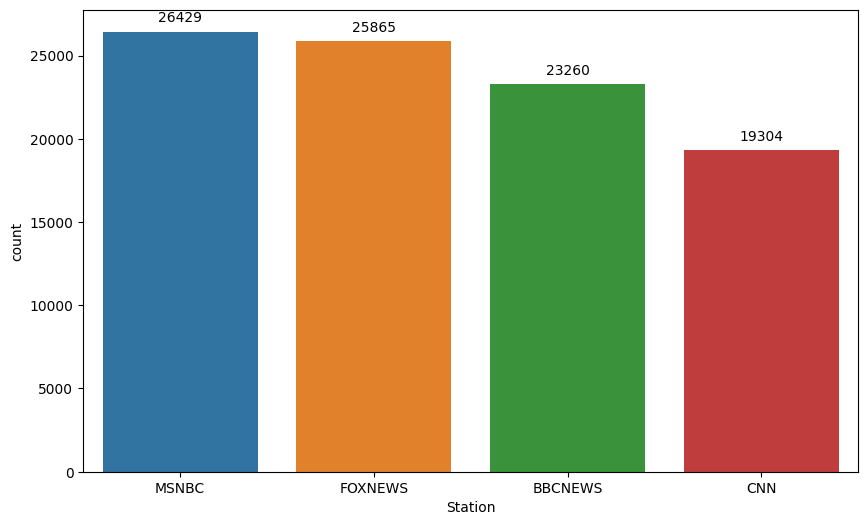

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Station', order=df['Station'].value_counts().index)
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x()+p.get_width()/2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

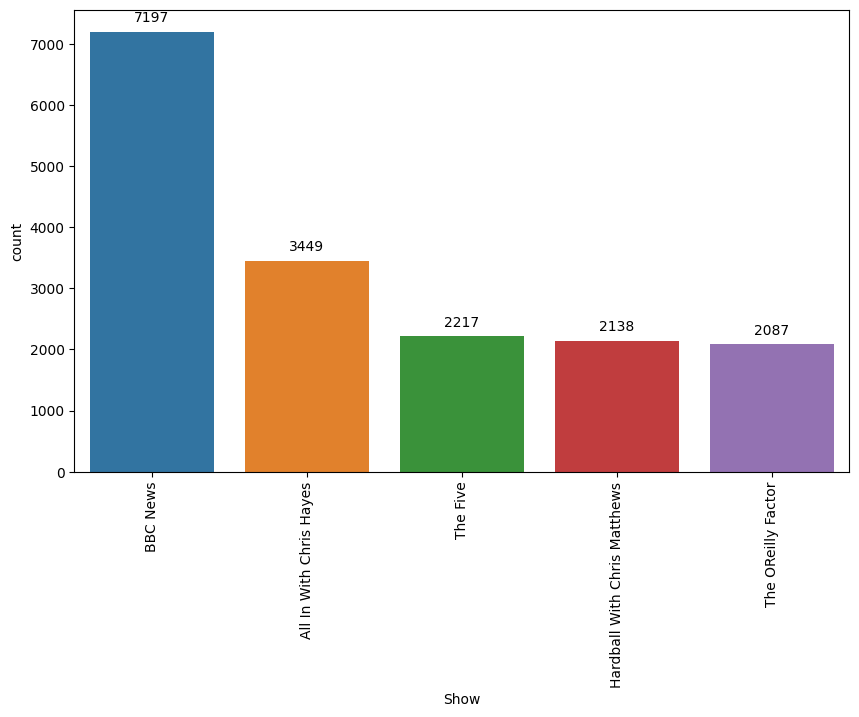

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Show', order=df['Show'].value_counts().index[:5])
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x()+p.get_width()/2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xticks(rotation=90)
plt.show()


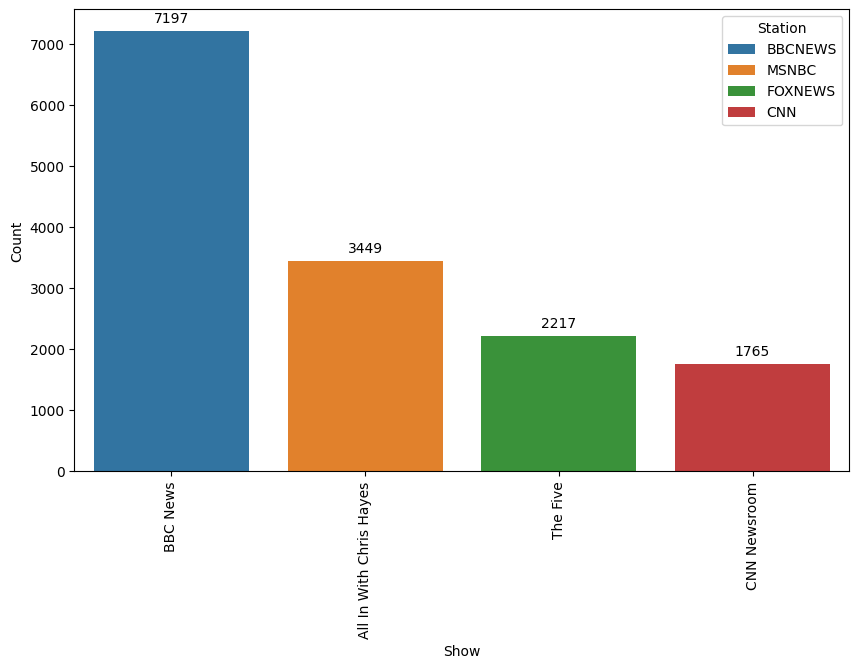

In [ ]:
# Find the top show from each station
top_shows = df.groupby('Station')['Show'].agg(lambda x:x.value_counts().index[0]).reset_index()
  # Add the count of each top show to the DataFrame
top_shows['Count'] = top_shows.apply(lambda row: df[(df['Station'] == row['Station']) & (df['Show'] == row['Show'])].shape[0], axis=1)

# Sort the DataFrame in descending order of Count
top_shows = top_shows.sort_values(by='Count', ascending=False)

# Plot the top shows
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=top_shows, x='Show', y='Count', hue='Station', dodge=False)

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.xticks(rotation=90)
plt.legend(title='Station')
plt.show()


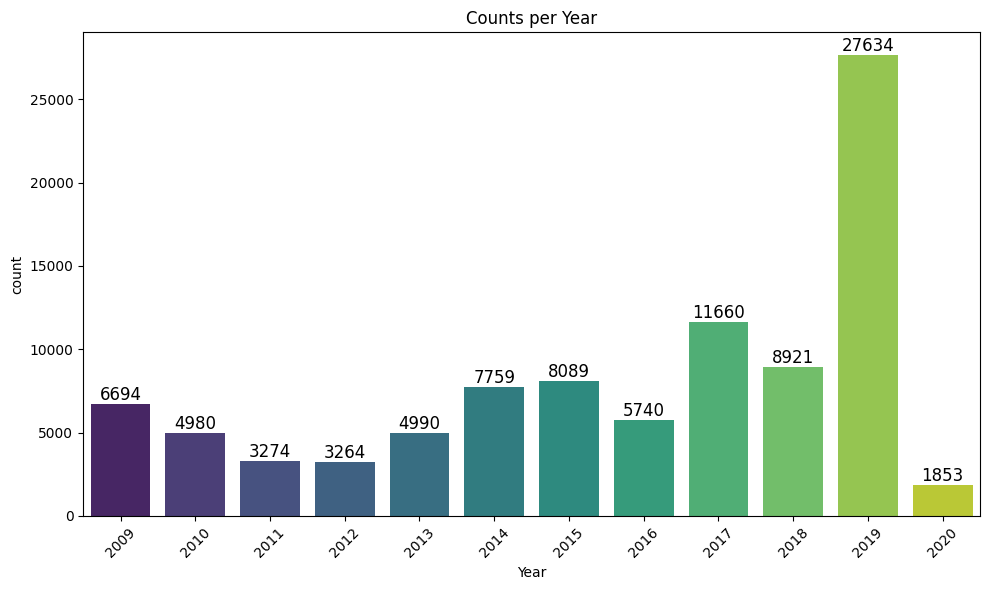

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Year', palette='viridis')

# Adding count labels on top of each bar
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()),
            fontsize=12, color='black', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.title("Counts per Year")
plt.tight_layout()
plt.show()


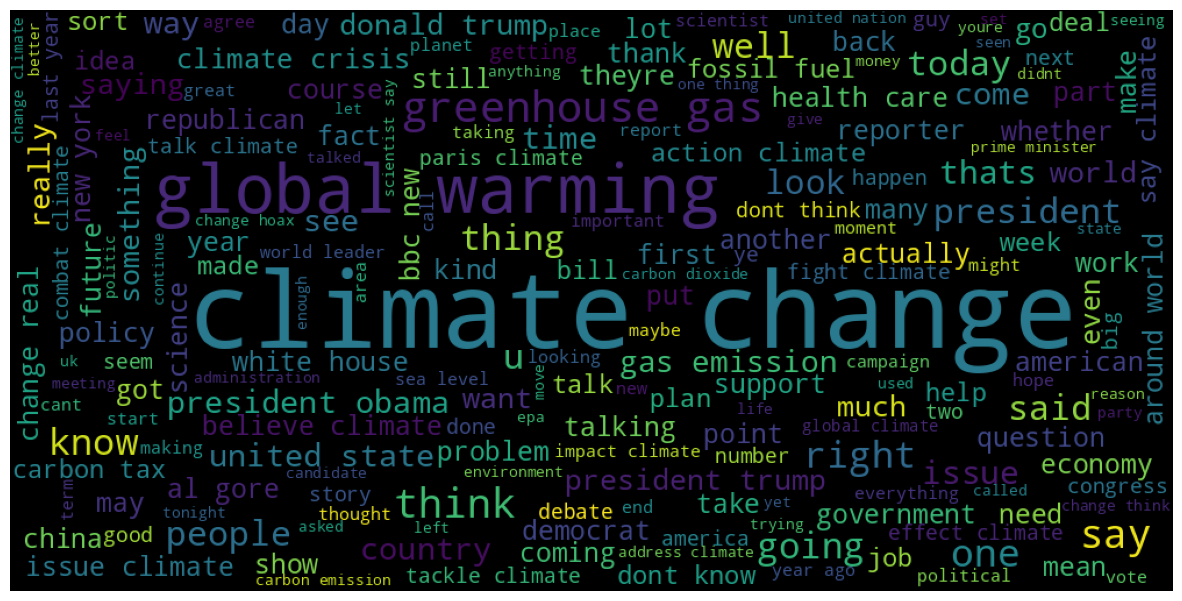

In [ ]:
# Word cloud for Snippet
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(df['Snippet']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
# Tokenize the Snippet texts
df['tokens'] = df['Snippet'].apply(lambda x: nltk.word_tokenize(x))

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['tokens'])

# Filter out words that occur less than 20 documents, or more than 50% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.5)

# Transform to bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=42)

# Visualize the topics
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_vis)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(score):
    if score < -0.05:
        return 'Negative'
    elif score > 0.05:
        return 'Positive'
    else:
        return 'Neutral'

def sentiment_analysis(df):
    df['sentiments'] = [get_sentiment(analyzer.polarity_scores(v)['compound']) for v in df['Snippet']]
    return df

df = sentiment_analysis(df)



                                                 URL  Station            Show  \
0  https://archive.org/details/BBCNEWS_20170805_1...  BBCNEWS        BBC News   
1  https://archive.org/details/BBCNEWS_20170805_1...  BBCNEWS        BBC News   
2  https://archive.org/details/BBCNEWS_20170808_2...  BBCNEWS  Outside Source   
3  https://archive.org/details/BBCNEWS_20170811_0...  BBCNEWS        BBC News   
4  https://archive.org/details/BBCNEWS_20170805_1...  BBCNEWS        BBC News   

                                 IAShowID  \
0        BBCNEWS_20170805_180000_BBC_News   
1        BBCNEWS_20170805_180000_BBC_News   
2  BBCNEWS_20170808_200000_Outside_Source   
3        BBCNEWS_20170811_020000_BBC_News   
4        BBCNEWS_20170805_180000_BBC_News   

                                      IAPreviewThumb  \
0  https://archive.org/download/BBCNEWS_20170805_...   
1  https://archive.org/download/BBCNEWS_20170805_...   
2  https://archive.org/download/BBCNEWS_20170808_...   
3  https://archive

Sentiment Distribution

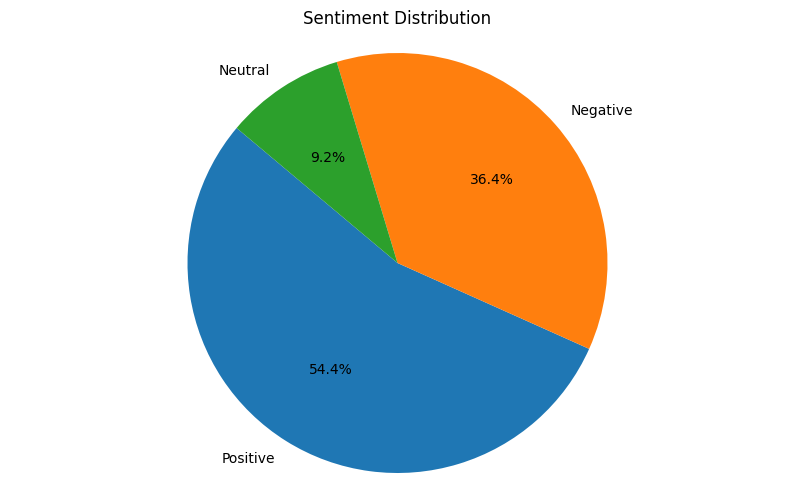

In [ ]:
# Count the number of each sentiment
sentiment_counts = df['sentiments'].value_counts()

# # Print the counts
# print(sentiment_counts)

# Plot the counts as a pie chart
plt.figure(figsize=(10, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Sentiment Over Time

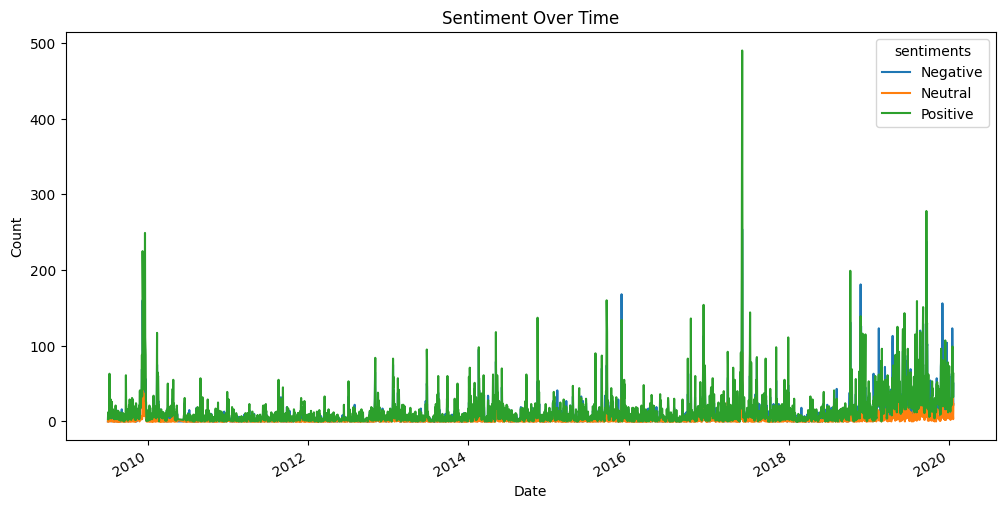

In [ ]:

df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Group by 'Date' and 'sentiments', then unstack 'sentiments' to create a DataFrame
# where each sentiment has its own column. Fill NA values with 0.
df_sentiments_over_time = df.groupby(['Date', 'sentiments']).size().unstack(fill_value=0)

# Plot
df_sentiments_over_time.plot(kind='line', stacked=False, figsize=(12, 6))
plt.title('Sentiment Over Time')
plt.ylabel('Count')
plt.show()




Negative Sentiments over time

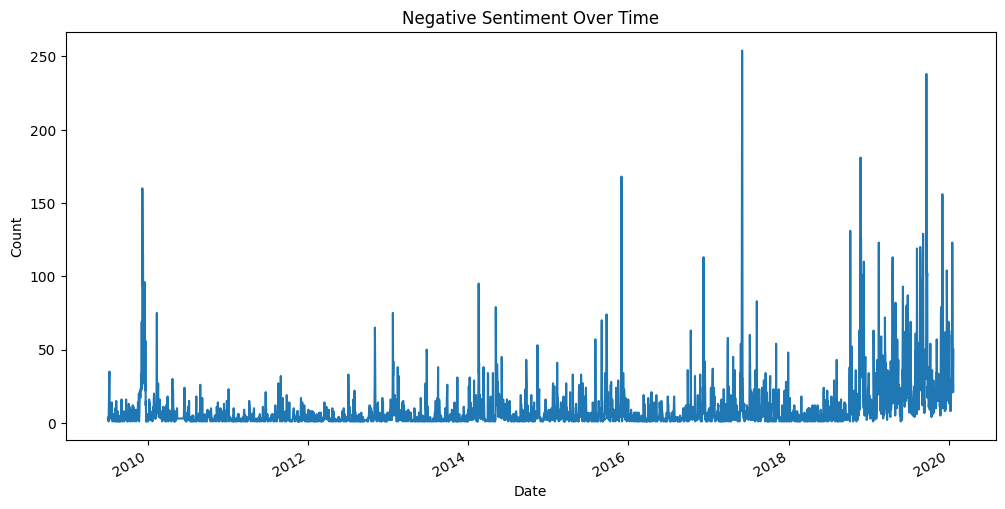

In [ ]:
# Filter the dataframe for 'negative' sentiments
df_negative = df[df['sentiments'] == 'Negative']

# Group by 'Date' and count the number of negative sentiments each day
df_negative_over_time = df_negative.groupby('Date').size()

# Plot
df_negative_over_time.plot(kind='line', figsize=(12, 6))
plt.title('Negative Sentiment Over Time')
plt.ylabel('Count')
plt.show()

Sentiment by Station

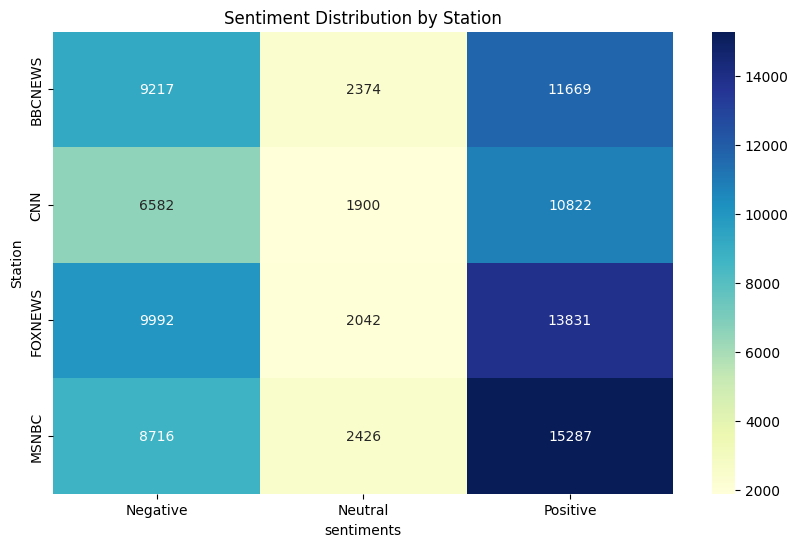

In [ ]:
# Group by 'Station' and 'sentiments' and count the number of occurrences
df_station_sentiments = df.groupby(['Station', 'sentiments']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(df_station_sentiments, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Sentiment Distribution by Station')
plt.show()

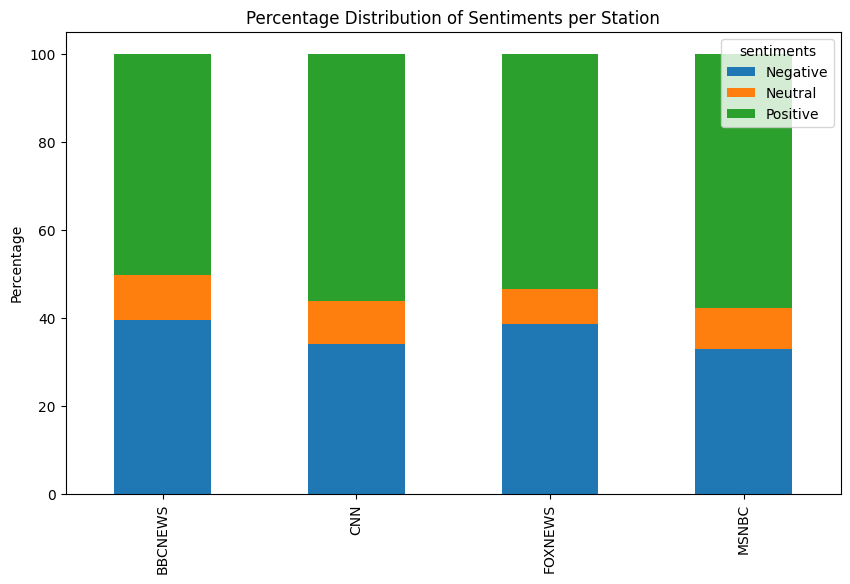

In [ ]:
# Total number of 'Snippet' for each 'Station'
total_snippet_per_station = df['Station'].value_counts()
# Total number of each 'sentiments' for each 'Station'
total_sentiments_per_station = df.groupby(['Station', 'sentiments']).size().unstack(fill_value=0)
# Calculate the percentage of each 'sentiments' type
percentage_sentiments_per_station = total_sentiments_per_station.divide(total_snippet_per_station, axis=0) * 100
# Plotting the percentage of each 'sentiments' type
percentage_sentiments_per_station.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Percentage Distribution of Sentiments per Station')
plt.ylabel('Percentage')
plt.show()